In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 436 (delta 22), reused 23 (delta 9), pack-reused 393 (from 1)
Receiving objects: 100% (436/436), 23.84 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/ELENA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 808.4 kB/s eta 0:00:00


In [2]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [3]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Writing /content/utils.py


In [4]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [5]:
from google.colab import files
uploaded = files.upload()



Saving SM_pot.m to SM_pot.m


In [6]:
#!/usr/bin/env python3
"""
Generic converter from a Mathematica DRalgo-style potential

    V[field_, T_] := expr

to a Python module potential_3d.py with

    def V(phi, T)
    def dV(phi, T)

that is numerically stable and ELENA-compatible.

- Works for ANY thermal potential with one scalar field and temperature T.
- Automatically detects all other symbols as parameters that must be provided
  by get_params(T).

Usage:
  1. Put your Mathematica definition (one line) into INPUT_FILE
     e.g.:
       V[phi_, T_] := (msq*ϕ^2)/2 + (λ*ϕ^4)/4 - ...

  2. Run:
       python generate_potential_generic.py

  3. You get `potential_3d.py`. Open it and implement get_params(T).
"""

import sympy as sp
from pathlib import Path
import re

# You already set this:
INPUT_FILE  = "SM_pot.m"
OUTPUT_FILE = "potential_3d.py"


# ------------------------------------------------------------------
# Helpers: Mathematica → SymPy-friendly string
# ------------------------------------------------------------------

# Common symbol name mappings used by DRalgo / SM / BSM models
MMA_SYMBOL_MAP = {
    # Field aliases (Unicode & escaped forms)
    "ϕ": "phi",
    "φ": "phi",
    "\\[CurlyPhi]": "phi",
    "\\[Phi]": "phi",

    # Lambdas
    "λ": "lam",
    "\\[Lambda]": "lam",
    "\\[Lambda]1H": "lam1H",

    # Mus / renormalisation scales
    "μ3US": "mu3US",
    "\\[Mu]3US": "mu3US",
    "\\[Mu]": "mu",

    # Hypercharges / generic charges / angles
    "Yϕ": "Yphi",
    "\\[Alpha]": "alpha",
    "\\[Beta]": "beta",

    # Standard Mathematica builtins
    "Pi": "pi",
    "Sqrt": "sqrt",
    "Log": "log",
}


def extract_def_line(mathematica_str: str):
    """
    Find the last definition line of the form

        V[field_, T_] := expr

    and return:

        field_name, T_name, rhs_string

    with field_name / T_name stripped of underscores.
    """
    lines_with_def = [ln for ln in mathematica_str.splitlines() if ":=" in ln]
    if not lines_with_def:
        raise ValueError("Could not find ':=' in input file.")

    last = lines_with_def[-1]

    # Extract the part between 'V[' and ']:='
    try:
        inside = last.split("V[", 1)[1].split("]:=", 1)[0]
    except IndexError as e:
        raise ValueError(
            "Could not parse the V[field_, T_] definition line. "
            "Make sure it has the form 'V[phi_, T_] := ...'."
        ) from e

    # Split arguments: e.g. "phi_, T_" -> "phi_", "T_"
    parts = [p.strip() for p in inside.split(",")]
    if len(parts) != 2:
        raise ValueError(
            f"Expected two arguments in V[...], found: {inside!r}"
        )

    field_part, T_part = parts
    field_name = field_part.replace("_", "").strip()
    T_name     = T_part.replace("_", "").strip()

    rhs = last.split(":=", 1)[1].strip()
    return field_name, T_name, rhs


def mathematica_to_sympy(expr: str) -> str:
    """
    Generic textual conversion from Mathematica syntax to something SymPy can parse.
    Handles:
      - greek / escaped letters like ϕ, \\[CurlyPhi], λ, \\[Lambda]1H, μ3US, \\[Mu]3US
      - Pi, Sqrt, Log
      - power ^ to **
      - [ ] to ( )
    Everything else is left untouched so it's model-agnostic.
    """
    # Symbol-level replacements
    for old, new in MMA_SYMBOL_MAP.items():
        expr = expr.replace(old, new)

    # Structural replacements
    expr = expr.replace("^", "**")
    expr = expr.replace("[", "(")
    expr = expr.replace("]", ")")
    return expr


def make_half_powers_safe(expr: sp.Expr) -> sp.Expr:
    """
    Replace half-integer powers x^(n/2) with Abs(x)^(n/2) to avoid complex/NaN
    when x is slightly negative due to numerics.

    This catches things like (msq + lam*phi**2)**(3/2), ( ... )**(1/2), etc.
    """

    def repl_pow(e):
        if isinstance(e, sp.Pow) and isinstance(e.exp, sp.Rational) and e.exp.q == 2:
            # e.base**(m/2)  ->  Abs(e.base)**(m/2)
            return sp.Pow(sp.Abs(e.base), e.exp)
        return e

    return expr.replace(
        lambda e: isinstance(e, sp.Pow)
        and isinstance(e.exp, sp.Rational)
        and e.exp.q == 2,
        repl_pow,
    )


def sympy_to_numpy_code(expr: sp.Expr) -> str:
    """
    Convert SymPy expression to a Python/NumPy-friendly code string.
    - uses sympy.pycode
    - then replaces sqrt/log/pi/Abs with safe NumPy wrappers
    """
    code = sp.pycode(expr)  # e.g. sqrt(...), log(...), pi, Abs(...)

    # sqrt -> _rtabs (numerically safe absolute sqrt)
    code = re.sub(r"\bsqrt\(", "_rtabs(", code)

    # log -> _logsafe (numerically safe log)
    code = re.sub(r"\blog\(", "_logsafe(", code)

    # pi -> np.pi
    code = re.sub(r"\bpi\b", "np.pi", code)

    # Abs -> np.abs
    code = re.sub(r"\bAbs\(", "np.abs(", code)

    return code


# ------------------------------------------------------------------
# Main generator
# ------------------------------------------------------------------

def main():
    # 1. Read Mathematica potential
    src = Path(INPUT_FILE).read_text(encoding="utf-8")

    # Extract field / T names and RHS of the potential
    field_name_raw, T_name_raw, rhs_raw = extract_def_line(src)
    rhs_sympy_like = mathematica_to_sympy(rhs_raw)

    # 2. Build SymPy expression
    # We *canonicalise* the Python interface to use 'phi' and 'T'
    phi, T = sp.symbols("phi T", real=True)

    # Let SymPy create symbols for anything else automatically.
    # Map both the original Mathematica argument names and the
    # canonical names so it works whether rhs uses 'phi' or '\\[CurlyPhi]'.
    local_map = {
        field_name_raw: phi,
        T_name_raw: T,
        "phi": phi,
        "T": T,
        "sqrt": sp.sqrt,
        "log": sp.log,
        "pi": sp.pi,
    }

    V_expr = sp.sympify(rhs_sympy_like, locals=local_map)

    # 2b. Make all half-integer powers sqrt-safe
    V_expr = make_half_powers_safe(V_expr)

    # 3. Find all free parameters (symbols) except phi and T
    free_syms = V_expr.free_symbols
    free_syms = sorted(free_syms, key=lambda s: s.name)
    param_syms = [s for s in free_syms if s not in (phi, T)]

    param_names = [s.name for s in param_syms]
    param_names_str = ", ".join(param_names) if param_names else "(none)"

    # Some light classification (just for the header)
    gauge_like   = [n for n in param_names if n.startswith("g")]
    quartic_like = [n for n in param_names if n.startswith("lam")]
    mass_like    = [n for n in param_names if n.startswith("m") or n.endswith("2")]

    # 4. Convert expression to NumPy-friendly string
    V_numpy = sympy_to_numpy_code(V_expr)

    # 5. Build the potential_3d.py text
    header = f'''"""
Auto-generated potential_3d.py from Mathematica DRalgo output.

Original definition:
    V[{field_name_raw}_, {T_name_raw}_] := ...

Python interface:
    V(phi, T)  — one-field 3D effective potential (thermal or not)
    dV(phi, T) — finite-difference derivative wrt phi

Detected free parameters (besides phi, T):
    {param_names_str}

Rough classification:
    - gauge-like:   {", ".join(gauge_like)   or "none detected"}
    - quartic-like: {", ".join(quartic_like) or "none detected"}
    - mass-like:    {", ".join(mass_like)    or "none detected"}

You MUST implement get_params(T) below to provide numerical values
for these parameters at any given temperature T.

Typical usage in ELENA:
    from potential_3d import V, dV
"""

import numpy as np

# ---------- numerically safe helpers ----------

def _rtabs(x, floor=1e-30):
    \"\"\"sqrt(|x|) with a floor to avoid NaNs from tiny negatives.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x, floor=1e-30):
    \"\"\"log(|x|) with a floor to avoid log(0) / log(negative) issues.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.log(np.maximum(np.abs(x), floor))


def get_params(T):
    \"\"\"
    USER MUST IMPLEMENT.

    Given a temperature T (float), return a dict mapping parameter names to values.
    Required keys:
        {param_names_str}

    Example:
        return dict(msq=..., lam=..., gw=..., gY=..., mu3US=...)
    \"\"\"
    raise NotImplementedError(
        "Implement get_params(T) so that it returns a dict with keys: {param_names_str}"
    )

'''

    # parameter extraction inside V
    if param_names:
        param_extract_lines = [
            f"    {name} = params['{name}']"
            for name in param_names
        ]
    else:
        param_extract_lines = ["    # no extra parameters"]
    param_extract_code = "\n".join(param_extract_lines)

    V_def = f'''
def V(phi, T):
    \"\"\"3D effective potential V(phi, T) translated from Mathematica.\"\"\"
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    params = get_params(T)
{param_extract_code}

    return {V_numpy}
'''

    dV_def = r'''
def dV(phi, T, h_rel=1e-3, h_abs=1e-5):
    """
    Numerical derivative dV/dphi via symmetric finite differences.
    Works for scalar phi or NumPy arrays of phi.
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    h = h_rel * np.maximum(np.abs(phi), 1.0) + h_abs
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)
'''

    out_text = header + V_def + dV_def
    Path(OUTPUT_FILE).write_text(out_text, encoding="utf-8")
    print(f"Wrote {OUTPUT_FILE} with generic V(phi,T) and dV(phi,T).")
    print("Free parameters:", param_names_str)


if __name__ == "__main__":
    main()


Wrote potential_3d.py with generic V(phi,T) and dV(phi,T).
Free parameters: gY, gw, lam1H, m2, mu3US


In [7]:
from pathlib import Path

# 1. Load the current potential_3d.py
path = Path("potential_3d.py")
text = path.read_text()

# 2. New full definition of get_params(T) for SM-like Higgs sector
new_get_params = """
def get_params(T):
    \"\"\"
    Example 4D → 3D matching for an SM-like Higgs sector.

    This is a placeholder: you MUST adjust the 4D input values and
    thermal mass coefficients to match your DRalgo output.

    Returns a dict with keys:
        gw, gY, lam1H, m2, mu3US
    \"\"\"
    T = float(T)

    # ---- 4D input couplings (set these to your DRalgo values) ----
    gw_4    = 0.65      # SU(2)_L gauge coupling at some scale
    gY_4    = 1      # U(1)_Y gauge coupling
    lam1H_4 = 1.65e-3     # Higgs quartic
    m2_4    = -(130.0**2)  # Higgs mass parameter (example)

    # ---- Simple DR-like matching (toy example; refine later) ----
    # 3D gauge couplings squared ~ g^2 T
    gw3_sq = gw_4**2 * T
    gY3_sq = gY_4**2 * T

    # 3D quartic ~ λ T (very rough; replace with your DRalgo result)
    lam1H_3 = lam1H_4 * T

    # Thermal mass: m2(T) = m2_4 + c_T T^2  (put your actual c_T here)
    cT_h = 0.4 * gw_4**2 + 0.2 * gY_4**2 + 0.1 * lam1H_4  # placeholder
    m2_3 = m2_4 + cT_h * T*T

    # 3D renormalisation scale (you may want mu3US ~ g T or ~ 2π T)
    mu3US = max(2.0 * np.pi * T, 1.0)

    # Convert g^2 -> g for the potential
    gw_3 = np.sqrt(gw3_sq)
    gY_3 = np.sqrt(gY3_sq)

    return dict(
        gw=gw_3,
        gY=gY_3,
        lam1H=lam1H_3,
        m2=m2_3,
        mu3US=mu3US,
    )
"""

# 3. Replace everything from 'def get_params(T):' up to the next 'def V('
start = text.index("def get_params(T):")
end   = text.index("def V(", start)   # assume V is the next function after get_params

new_text = text[:start] + new_get_params + "\n\n" + text[end:]

# 4. Write patched file
path.write_text(new_text)


32809

In [8]:

import re
from pathlib import Path

path = Path("potential_3d.py")
text = path.read_text()

# Remove all math. prefixes
text = text.replace("math._rtabs", "_rtabs")
text = text.replace("math._logsafe", "_logsafe")
text = text.replace("math.np.pi", "np.pi")
text = text.replace("math.", "")   # remove any leftover math.

# Clean accidental double prefixes
text = text.replace("np.np", "np")

# Write cleaned file
path.write_text(text)



31134

In [9]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Writing custom_model.py


In [10]:
import numpy as np
from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")


phi_test = 10.0
T_test   = 150.0
print("V(10, 150) =", V(phi_test, T_test))
print("dV(10, 150) =", dV(phi_test, T_test))


lambda = 0.00165
g      = 0.54
vev    = 500 MeV
V(10, 150) = -566609.5971219694
dV(10, 150) = -92700.11485096293


In [ ]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal, model-agnostic wrapper around potential_3d.V and potential_3d.dV.

    - Exposes `DVtot(phi, T)` and `gradV(phi, T)` as expected by ELENA's machinery.
    - Does NOT assume any specific set of couplings (lambda, g, gw, gY, etc.).
    - You can still pass metadata (4D couplings, description, etc.) via **params.

    Typical usage:
        dp = CustomModel(vev=500.0,
                         xstep=0.5,
                         Tstep=0.5,
                         units="MeV",
                         gw=0.65, gY=0.36, lam1H=0.13,
                         description="SM-like Higgs DR potential")

        V  = dp.DVtot
        dV = dp.gradV
    """

    def __init__(self, vev, xstep, Tstep, units="MeV", **params):
        """
        Parameters
        ----------
        vev : float
            Reference vev scale (used only as metadata here).
        xstep : float
            Step in field space for scans (ELENA-style).
        Tstep : float
            Step in temperature for scans (ELENA-style).
        units : str, optional
            Energy units label (e.g. 'GeV', 'MeV'), for bookkeeping.
        **params :
            Arbitrary extra metadata (e.g. gw=..., gY=..., lam1H=..., description=...).
            This does NOT affect the potential directly; the actual T-dependence of
            couplings is implemented inside potential_3d.get_params(T).
        """
        self.vev   = float(vev)
        self.xstep = float(xstep)
        self.Tstep = float(Tstep)
        self.units = units

        # Store all extra info (couplings, descriptions, etc.)
        self.params = params

        # If you want to use these params to *modify* get_params(T),
        # you would do that inside potential_3d.get_params(T), not here.

        # ELENA-compatible callables:
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)

    def info(self):
        """
        Convenience helper: print a short summary of the model metadata.
        """
        print("CustomModel info")
        print("----------------")
        print(f"vev   = {self.vev} {self.units}")
        print(f"xstep = {self.xstep} {self.units}")
        print(f"Tstep = {self.Tstep} {self.units}")
        if self.params:
            print("extra params:")
            for k, v in self.params.items():
                print(f"  {k} = {v}")
        else:
            print("extra params: (none)")


Overwriting custom_model.py


/content/ELENA/potential_3d.py:100: RuntimeWarning: invalid value encountered in divide
  return (1/2)*gY**4*((1/128)*gw**2*phi**4*(gY**2 + gw**2)/np.pi**2 + (1/128)*gw**2*phi**2*abs(phi)*_rtabs(abs(gY**2 + gw**2))*_rtabs(abs(lam1H*phi**2 + m2))/np.pi**2 + (1/128)*phi**2*(gY**2 + gw**2)*_rtabs(abs(gw**2))*abs(phi)*_rtabs(abs(lam1H*phi**2 + m2))/np.pi**2 - 1/64*phi**2*((1/4)*gw**2*phi**2 - lam1H*phi**2 - m2 + (1/4)*phi**2*(gY**2 + gw**2))*_rtabs(abs(gw**2))*_rtabs(abs(gY**2 + gw**2))/np.pi**2 - 1/16*(lam1H*phi**2 + m2)**2*(_logsafe(mu3US/_rtabs(abs(lam1H*phi**2 + m2))) + 1/2)/np.pi**2 + (1/16)*(_logsafe(mu3US/((1/2)*_rtabs(abs(gw**2))*abs(phi) + _rtabs(abs(lam1H*phi**2 + m2)))) + 1/2)*((1/4)*gw**2*phi**2 - lam1H*phi**2 - m2)**2/np.pi**2 + (1/16)*(_logsafe(mu3US/((1/2)*abs(phi)*_rtabs(abs(gY**2 + gw**2)) + _rtabs(abs(lam1H*phi**2 + m2)))) + 1/2)*(-lam1H*phi**2 - m2 + (1/4)*phi**2*(gY**2 + gw**2))**2/np.pi**2 - 1/16*(_logsafe(mu3US/((1/2)*_rtabs(abs(gw**2))*abs(phi) + (1/2)*abs(phi)*_rtab

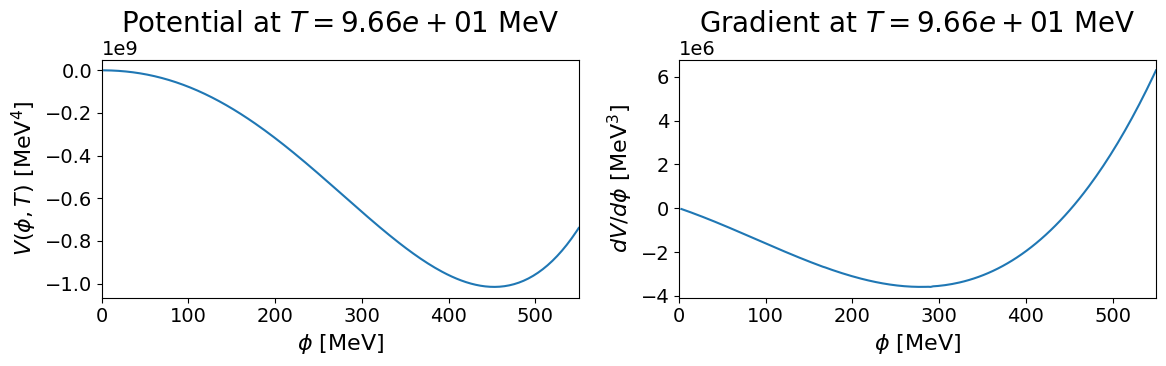

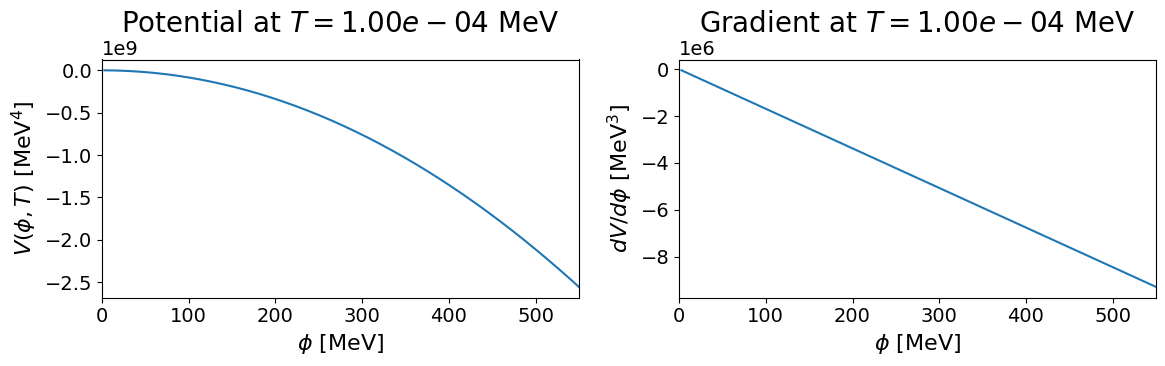

In [19]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'text.usetex': False    # <<< IMPORTANT for Colab
})

T = np.random.uniform(0, vev)

phi = np.linspace(0, 1.1 * vev, 200)
phi = phi.reshape(-1,1)

for t in [T, 0.0001]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(f"$\\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\\phi, T)$ [{units}$^4$]")

    axes[1].plot(phi[1:], dv[1:])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\\phi$ [{units}$^3$]")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()



In [26]:
%%writefile veff_4d.py
"""
veff_4d.py – 4D one-loop + high-T thermal potential for the SM Higgs direction.

Background field:
    φ ≡ sqrt(2) Re(H^0)

Gauge group:
    SU(2)_L with coupling gw
    U(1)_Y  with coupling gY

Scalar potential (tree level):
    V_tree(φ) = ½ m2 φ^2 + ¼ lam1H φ^4

We include thermal contributions from:
    - Higgs h
    - 3 Goldstones (G^0, G^±)
    - W bosons (W±)
    - Z boson
    - top quark t

High-T expansion:
    Bosons:  ΔV_T ≈ n [ (m^2 T^2)/24  −  (m^3 T)/(12π) ]
    Fermions: ΔV_T ≈ n [ (m^2 T^2)/48 ]
(φ-independent T^4 pieces and m^4 log terms are dropped.)
"""

import numpy as np

# ---------- 4D input couplings (example values – set to your DRalgo ones) ----------
gw     = 0.54          # SU(2)_L gauge coupling
gY     = 0.1          # U(1)_Y  gauge coupling
lam1H  = 1.65e-3          # Higgs quartic λ_H
m2     = -(130.0**2)    # Higgs mass^2 parameter (can be tuned)
yt     = 0.99          # top Yukawa (example)

# ---------- mass spectra along the Higgs background (Landau gauge, tree level) ----------

def m_h2(phi):
    """Higgs mass^2: m^2 + 3 λ φ^2."""
    return m2 + 3.0 * lam1H * phi * phi

def m_G2(phi):
    """Goldstone mass^2: m^2 + λ φ^2 (3 Goldstones in SM)."""
    return m2 + lam1H * phi * phi

def m_W2(phi):
    """W boson mass^2: m_W^2 = (gw^2 / 4) φ^2."""
    return 0.25 * (gw**2) * phi * phi

def m_Z2(phi):
    """Z boson mass^2: m_Z^2 = (gw^2 + gY^2)/4 * φ^2."""
    return 0.25 * (gw**2 + gY**2) * phi * phi

def m_t2(phi):
    """Top quark mass^2: m_t^2 = (yt^2 / 2) φ^2."""
    return 0.5 * (yt**2) * phi * phi

# Degeneracy factors (d.o.f.)
n_h = 1.0   # Higgs
n_G = 3.0   # Goldstones
n_W = 6.0   # W±: 2 charges × 3 polarisations
n_Z = 3.0   # Z: 3 polarisations
n_t = 12.0  # top quark: 3 colors × 2 (particle/anti) × 2 spin

# ---------- tree-level potential ----------

def V_tree(phi):
    """Tree-level Higgs potential in 4D SM."""
    return 0.5 * m2 * phi * phi + 0.25 * lam1H * (phi**4)


# ---------- high-T thermal pieces ----------

def V_T_boson(m2, n, T):
    """
    High-T expansion of bosonic thermal potential (keeping T^2 and cubic term):

    ΔV_T ≈ n * [ (m^2 T^2)/24  -  (m^3 T)/(12π) ]
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m2_clip = np.maximum(m2, 0.0)   # avoid sqrt of negative
    m  = np.sqrt(m2_clip)

    term_T2 = (m2 * (T**2)) / 24.0
    term_T3 = - (m**3 * T) / (12.0 * np.pi)

    return n * (term_T2 + term_T3)


def V_T_fermion(m2, n, T):
    """
    High-T expansion of fermionic thermal potential (φ-dependent part):

    ΔV_T^F ≈ n * (m^2 T^2) / 48

    (Overall minus sign and T^4 term are φ-independent and dropped.)
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    term_T2 = (m2 * (T**2)) / 48.0
    return n * term_T2


# ---------- full 4D one-loop + thermal effective potential ----------

def V(phi, T):
    """
    4D SM effective potential V_4D(φ,T) in high-T approximation
    along the neutral Higgs direction.

    This is the 4D method to compare with your 3D DR potential.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)

    # tree level
    V0 = V_tree(phi)

    # masses
    mh2 = m_h2(phi)
    mG2 = m_G2(phi)
    mW2 = m_W2(phi)
    mZ2 = m_Z2(phi)
    mt2 = m_t2(phi)

    # thermal pieces
    VTh = V_T_boson(mh2, n_h, T)
    VTG = V_T_boson(mG2, n_G, T)
    VTW = V_T_boson(mW2, n_W, T)
    VTZ = V_T_boson(mZ2, n_Z, T)
    VTt = V_T_fermion(mt2, n_t, T)

    return V0 + VTh + VTG + VTW + VTZ + VTt


# ---------- numerical derivative dV/dφ ----------

def dV(phi, T):
    """
    Numerical derivative dV/dφ using a symmetric finite difference.

    Step size is independent of φ near zero to stay stable with |φ| cusps.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


if __name__ == "__main__":
    # quick sanity print
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 50.0, 100.0, 200.0]:
            print(f"T={T:6.1f}, phi={ph:7.2f}, V4D={V(ph,T): .4e}, dV4D={dV(ph,T): .4e}")
        print("-"*60)


Overwriting veff_4d.py


In [27]:
import numpy as np
import matplotlib.pyplot as plt

from potential_3d import V as V_DR, dV as dV_DR    # your 3D DR potential
from veff_4d   import V as V_4D, dV as dV_4D    # new 4D potential


In [28]:
def compare_DR_vs_4D_multi(phi, Ts, units=r"\mathrm{MeV}"):


    import numpy as np
    import matplotlib.pyplot as plt

    plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,  # True if you have LaTeX in your environment
})


    # Ensure phi is 1D for plotting
    phi = np.asarray(phi).reshape(-1)

    # Round temperatures for nice labels
    Ts = np.asarray(Ts, dtype=float)
    Ts_round = Ts.astype(int)

    # Figure & axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Nice global style tweaks
    for ax in axes.flat:
        ax.tick_params(direction="in", top=True, right=True)
        ax.grid(alpha=0.25)

    # Colour map: same colour for a given T (solid=DR, dashed=4D)
    colors = plt.cm.viridis(np.linspace(0, 1, len(Ts_round)))

    for T, Tlab, color in zip(Ts, Ts_round, colors):
        V1  = V_DR(phi, T)
        V2  = V_4D(phi, T)-V_4D(0.0, T)
        dV1 = dV_DR(phi, T)
        dV2 = dV_4D(phi, T)

        dVpot = V1 - V2
        dGrad = dV1 - dV2

        # --- Potentials ---
        axes[0, 0].plot(phi, V1,  color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[0, 0].plot(phi, V2,  color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- ΔV ---
        axes[0, 1].plot(phi, dVpot, color=color,
                        label=rf"$T={Tlab}$")

        # --- Gradients ---
        axes[1, 0].plot(phi, dV1, color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[1, 0].plot(phi, dV2, color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- Δ(dV) ---
        axes[1, 1].plot(phi, dGrad, color=color,
                        label=rf"$T={Tlab}$")

    # Horizontal zero lines for the difference plots
    axes[0, 1].axhline(0.0, ls="--", color="grey", lw=1)
    axes[1, 1].axhline(0.0, ls="--", color="grey", lw=1)

    # Titles and axis labels
    axes[0, 0].set_title(r"$V_{\mathrm{eff}}(\phi, T)$")
    axes[0, 1].set_title(r"$\Delta V(\phi, T) = V_{\rm DR} - V_{\rm 4D}$")
    axes[1, 0].set_title(r"$\partial_\phi V_{\mathrm{eff}}(\phi, T)$")
    axes[1, 1].set_title(r"$\Delta(\partial_\phi V) = \partial_\phi V_{\rm DR} - \partial_\phi V_{\rm 4D}$")

    axes[1, 0].set_xlabel(r"$\phi\ [{"+units+"}]$")
    axes[1, 1].set_xlabel(r"$\phi\ [{"+units+"}]$")

    axes[0, 0].set_ylabel(r"$V_{\mathrm{eff}}\ [{"+units+r"}^4]$")
    axes[0, 1].set_ylabel(r"$\Delta V\ [{"+units+r"}^4]$")
    axes[1, 0].set_ylabel(r"$\partial_\phi V\ [{"+units+r"}^3]$")
    axes[1, 1].set_ylabel(r"$\Delta(\partial_\phi V)\ [{"+units+r"}^3]$")

    # Legends (smaller, non-overlapping)
    axes[0, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[0, 1].legend(frameon=False, fontsize=11)
    axes[1, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[1, 1].legend(frameon=False, fontsize=11)

    plt.tight_layout()
    plt.show()


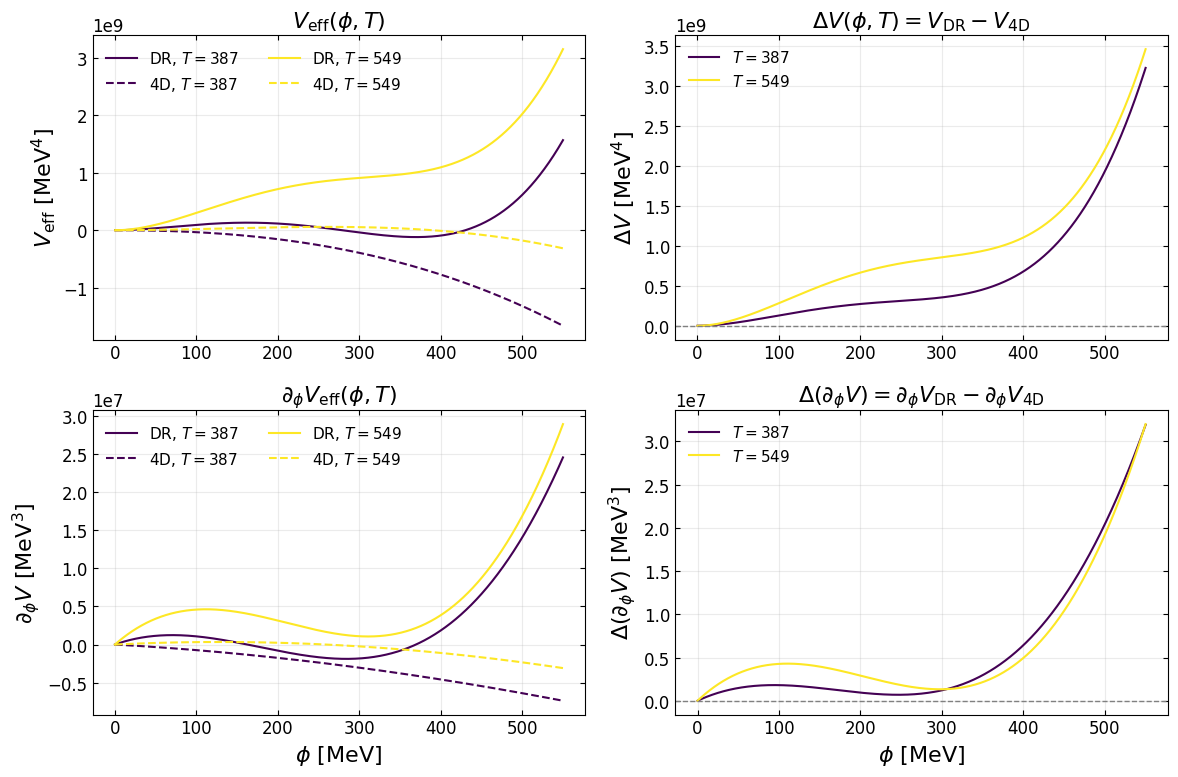

In [30]:
phi = np.linspace(0, 1.1*vev, 2601)
phi = phi.reshape(-1,1)
Ts  = np.random.uniform(0, 2.5*vev, size=2)
Ts = np.round(Ts).astype(int)
compare_DR_vs_4D_multi(phi, Ts)
